Data gotten from: https://ourworldindata.org/plastic-pollution
<br>Macroplastics direct download: blob:https://ourworldindata.org/2b8afb92-61f4-4e42-ae6f-a5d474fdb4af
<br>Microplastics direct download: blob:https://ourworldindata.org/8096a9c4-99fd-46e0-baf3-326cf240db04

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)


In [60]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
df_micro = pd.read_csv('/content/drive/My Drive/AI/microplastics-in-ocean.csv')
df_micro.head()
df_macro = pd.read_csv('/content/drive/My Drive/AI/macroplastics-in-ocean.csv')
df_macro.head()
df_join = df_macro.join(df_micro['Accumulated ocean plastic: Microplastics (<0.5cm)'])
df_join = df_join.drop('Code', axis=1)
df_join.head()


,Entity,Year,Accumulated ocean plastic: Macroplastics (>0.5cm),Accumulated ocean plastic: Microplastics (<0.5cm)
0,Emissions growth to 2050,1950,0,0
1,Emissions growth to 2050,1951,400,0
2,Emissions growth to 2050,1952,600,0
3,Emissions growth to 2050,1953,1000,0
4,Emissions growth to 2050,1954,1300,100


In [62]:
total = []
for row in range(df_join.Entity.count()):
    total.append(df_join['Accumulated ocean plastic: Macroplastics (>0.5cm)'][row] + df_join['Accumulated ocean plastic: Microplastics (<0.5cm)'][row])
df_final = df_join
df_final['Total Plastics in the ocean'] = total

In [63]:
df_final.head()

,Entity,Year,Accumulated ocean plastic: Macroplastics (>0.5cm),Accumulated ocean plastic: Microplastics (<0.5cm),Total Plastics in the ocean
0,Emissions growth to 2050,1950,0,0,0
1,Emissions growth to 2050,1951,400,0,400
2,Emissions growth to 2050,1952,600,0,600
3,Emissions growth to 2050,1953,1000,0,1000
4,Emissions growth to 2050,1954,1300,100,1400


In [64]:
df_final = df_final[(df_final.Entity == 'Emissions level to 2020')]
df_final = df_final.drop(['Entity','Accumulated ocean plastic: Macroplastics (>0.5cm)','Accumulated ocean plastic: Microplastics (<0.5cm)'],axis=1)
print(df_final)

     Year  Total Plastics in the ocean
101  1950                            0
102  1951                          400
103  1952                          600
104  1953                         1000
105  1954                         1400
..    ...                          ...
197  2046                      4351000
198  2047                      4459100
199  2048                      4567700
200  2049                      4676800
201  2050                      4786400

[101 rows x 2 columns]


In [65]:
df_actual = df_final[(df_final.Year <= 2020)]

df_train_split = df_actual.sample(frac=0.7, random_state=0).sort_values('Year')
df_test_split = df_actual.drop(df_train_split.index).sort_values('Year')

df_science_estimate = df_final[(df_final.Year > 2020)]

In [66]:
df_train_split.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year,50.0,1984.24,20.676873,1950.0,1966.5,1982.5,2001.75,2020.0
Total Plastics in the ocean,50.0,401326.00,501470.628603,0.0,19975.0,152750.0,636700.00,1771400.0


In [67]:
df_train_total_plastic = np.array(df_train_split['Total Plastics in the ocean'])
df_test_total_plastic = np.array(df_test_split['Total Plastics in the ocean'])


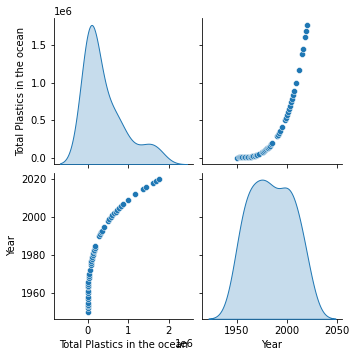

In [68]:
sns.pairplot(df_train_split[['Total Plastics in the ocean', 'Year']], diag_kind='kde');

In [69]:
print(df_train_total_plastic)

[      0     600    1000    1400    1900    3200    4100    6200    7400
   10800   13000   15300   18200   25300   29800   34900   46900   70000
   78800   88200   98400  109700  121300  133400  146000  159500  174100
  189300  281800  303400  326300  350400  403300  495900  530700  567600
  606100  646900  689600  734900  781800  831600  884200  991100 1170600
 1373900 1447300 1603200 1685600 1771400]


In [70]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [71]:
normalizer.adapt(df_train_split)

In [72]:
print(normalizer.mean.numpy())

[[  1984.24 401326.  ]]


In [73]:
first = np.array(df_train_split[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())


First example: [[1950    0]]

Normalized: [[-1.67 -0.81]]


In [74]:
year = np.array(df_train_split['Year'])

year_normalizer = layers.Normalization(input_shape=[1,], axis=None)
year_normalizer.adapt(year)



In [75]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.1))
  return model

In [76]:
dnn_plastic_model = build_and_compile_model(year_normalizer)


In [77]:
dnn_plastic_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                128       
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [78]:
%%time
history = dnn_plastic_model.fit(
    df_train_split['Year'],
    df_train_total_plastic,
    validation_split=0.2,
    verbose=0, epochs=10000)

CPU times: user 4min 3s, sys: 10.5 s, total: 4min 14s
Wall time: 3min 59s


In [79]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Total Plastic]')
  plt.legend()
  plt.grid(True)

This graph plots the error of the non-linear regression model, as shown in the graph it starts with a massive error and begins to tricle into less error as it learns

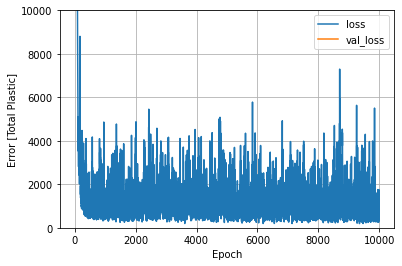

In [80]:
plot_loss(history)

In [81]:
def plot_totalPlasticByYear(x, y):
  plt.scatter(df_train_split['Year'], df_train_split['Total Plastics in the ocean'], label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Year')
  plt.ylabel('TotalPlastic')
  plt.legend()

In [87]:
x = tf.linspace(1950, 2020, 70)
y = dnn_plastic_model.predict(x)

In this graph you can see the current data ploted with the training data

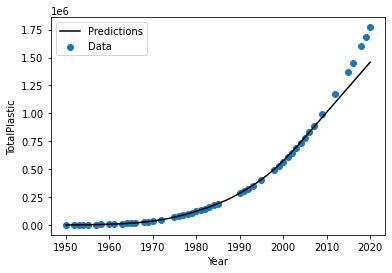

In [88]:
plot_totalPlasticByYear(x, y)

This graph plots the true already given value of the total plastics against the predition of total plastics

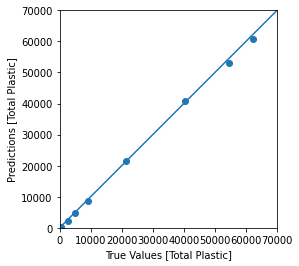

In [84]:
test_results = dnn_plastic_model.evaluate(df_test_split['Year'], df_test_total_plastic,verbose=0)
test_predictions = dnn_plastic_model.predict(df_test_split['Year']).flatten()

a = plt.axes(aspect='equal')
plt.scatter(df_test_total_plastic, test_predictions)
plt.xlabel('True Values [Total Plastic]')
plt.ylabel('Predictions [Total Plastic]')
lims = [0, 70000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

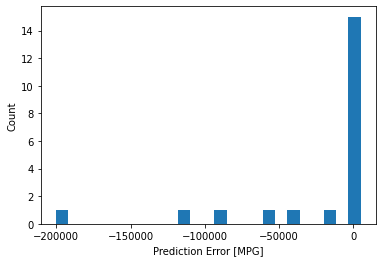

In [86]:
error = test_predictions - df_test_total_plastic
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')